# Competição FGV Quant e FGV Tech

## Descrição do Problema

A empresa quer desenvolver uma ferramenta de sugestão de preços de automóveis. O seu trabalho é criar um modelo preditivo usando como base os dados já disponíveis pela empresa.

## Métrica de Avaliação

Todos os modelos serão avaliados através do R2 entre o valor predito/valor estimado do modelo e o valor real dos dados do conjunto cars_test.

A pontuação R2 é o coeficiente de determinação do modelo

## Formato de Submissão

Submeta o arquivo em formato .csv somente com as colunas "id" e "selling_price", exemplo:

id,selling_price \
1,100000 \
2,1260000 \
3,900000

---

# Tentativa 3 - Ideias

- Normalizar todos os dados
    - Usar normalização one hot encoder em dados qualitativos?
    - Testar MinMaxScaler e StandardScaler no dados quant

1. Linearização L1

2. Linearização L2

3. Rodar Random Forest

4. Rodar Isolation Forest

# Analise dos dados

## Leitura dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.style.use('dark_background')


In [2]:
train = pd.read_csv('data/cars_train.csv')
test = pd.read_csv('data/cars_test.csv')

## Tratamento Inicial dos Dados

In [3]:
# Removendo os nulls do train
train = train.dropna()
train.isnull().sum()

id               0
name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [4]:
# Transformando as colunas Mileage, Engine e Max_power em int
train['mileage'] = train.loc[:,'mileage'].str.replace(r'\D', '').astype(int)
train['engine'] = train.loc[:,'engine'].str.replace(r'\D', '').astype(int)
train['max_power'] = train.loc[:,'max_power'].str.replace(r'\D', '').astype(int)

In [5]:
# Adicionando uma coluna para a marca do carro e outra para o modelo
train['marca'] = train.loc[:,'name'].str.split(' ').str[0]
train['model'] = train.loc[:,'name'].str.split(' ').str[0] + " " + train['name'].str.split(' ').str[1]

## Análise dos dados qualitativos

In [6]:
train_quali = train.loc[:,['fuel', 'seller_type', 'transmission', 'owner']]
train_quali

,fuel,seller_type,transmission,owner
0,Petrol,Individual,Manual,Second Owner
1,Petrol,Individual,Manual,First Owner
2,Diesel,Individual,Manual,First Owner
3,Petrol,Individual,Manual,Third Owner
4,Diesel,Dealer,Manual,First Owner
...,...,...,...,...
5684,Diesel,Dealer,Manual,First Owner
5685,Diesel,Trustmark Dealer,Manual,Second Owner
5686,Diesel,Individual,Manual,First Owner
5687,Diesel,Dealer,Manual,First Owner


In [7]:
for i in train_quali.columns:
    print(train_quali['%s' %(i)].value_counts())
    print('')

Diesel    3012
Petrol    2461
CNG         34
LPG         25
Name: fuel, dtype: int64

Individual          4591
Dealer               773
Trustmark Dealer     168
Name: seller_type, dtype: int64

Manual       4784
Automatic     748
Name: transmission, dtype: int64

First Owner             3670
Second Owner            1393
Third Owner              363
Fourth & Above Owner     103
Test Drive Car             3
Name: owner, dtype: int64



## Análise dos dados quantitativos

In [8]:
train_quant = train.copy().drop(columns=['id', 'name', 'torque', 'model'])
train_quant = train_quant.drop(columns=['fuel', 'seller_type', 'transmission', 'owner', 'marca'])
# train_quant

## Tratamento da base de teste

In [9]:
# Transformando as colunas Mileage, Engine e Max_power em int
test['mileage'] = test.loc[:,'mileage'].str.replace(r'\D', '').astype(int)
test['engine'] = test.loc[:,'engine'].str.replace(r'\D', '').astype(int)
test['max_power'] = test.loc[:,'max_power'].str.replace(r'\D', '').astype(int)

# Adicionando uma coluna para a marca do carro e outra para o modelo
test['marca'] = test.loc[:,'name'].str.split(' ').str[0]
test['model'] = test.loc[:,'name'].str.split(' ').str[0] + " " + train['name'].str.split(' ').str[1]


test = test.drop(columns = ['id','name','torque'])
test

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,marca,model
0,2018,25000,Petrol,Individual,Manual,First Owner,2121,1197,8180,5.0,Maruti,Maruti 800
1,2017,43000,Diesel,Dealer,Manual,First Owner,2254,1396,8873,5.0,Hyundai,Hyundai Baleno
2,2014,15000,Petrol,Individual,Manual,Second Owner,2274,796,473,5.0,Maruti,Maruti Innova
3,2017,60000,Diesel,Dealer,Automatic,Second Owner,1255,2982,1685,7.0,Toyota,Toyota Alto
4,2019,7032,Petrol,Trustmark Dealer,Automatic,First Owner,190,1199,8876,5.0,Honda,Honda Ecosport
...,...,...,...,...,...,...,...,...,...,...,...,...
2369,2015,53000,Petrol,Individual,Manual,Second Owner,2274,796,473,5.0,Maruti,Maruti Bolero
2370,2016,56494,Petrol,Trustmark Dealer,Manual,First Owner,182,1199,887,5.0,Honda,Honda Baleno
2371,2015,110000,Diesel,Individual,Manual,First Owner,2659,1248,74,5.0,Maruti,Maruti Alto
2372,2010,110000,Diesel,Individual,Manual,Second Owner,200,1399,68,5.0,Ford,Ford Xcent


----

## Modelagem

### Linear regression

In [10]:
# Removendo as colunas Id, name, torque, model
train_lr = train.copy().drop(columns = ['id','name','torque','model'])
train_lr = pd.get_dummies(train_lr)
train_lr.tail(5)

,year,selling_price,km_driven,mileage,engine,max_power,seats,fuel_CNG,fuel_Diesel,fuel_LPG,...,marca_Mercedes-Benz,marca_Mitsubishi,marca_Nissan,marca_Opel,marca_Renault,marca_Skoda,marca_Tata,marca_Toyota,marca_Volkswagen,marca_Volvo
5684,2016,515000,68609,227,1498,8984,5.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5685,2013,750000,79328,1299,2494,1006,7.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5686,2015,1125000,70000,154,2179,120,7.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5687,2017,844999,70000,2809,1248,885,5.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5688,2005,150000,120000,178,1399,68,5.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Removendo as colunas Id, name, torque, model
test_lr = test.copy().drop(columns = ['model'])
test_lr = pd.get_dummies(test_lr)
test_lr.tail(5)

,year,km_driven,mileage,engine,max_power,seats,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,...,marca_Maruti,marca_Mercedes-Benz,marca_Mitsubishi,marca_Nissan,marca_Renault,marca_Skoda,marca_Tata,marca_Toyota,marca_Volkswagen,marca_Volvo
2369,2015,53000,2274,796,473,5.0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2370,2016,56494,182,1199,887,5.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2371,2015,110000,2659,1248,74,5.0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2372,2010,110000,200,1399,68,5.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2373,2013,120000,232,1248,7394,5.0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
# Colunas iguais no Treino e Teste
cols_equal = []
for i in range(len(train_lr.columns)):
    for j in range(len(test_lr.columns)):
        if train_lr.columns[i] == test_lr.columns[j]:
            cols_equal.append(train_lr.columns[i])
            
# Colunas para dropar
cols_to_drop = train_lr.copy().drop(columns = cols_equal)
cols_to_drop

# 'marca_Ashok', 'marca_Daewoo', 'marca_Isuzu', 'marca_Land', 'marca_Opel'

,selling_price,marca_Ashok,marca_Daewoo,marca_Isuzu,marca_Land,marca_Opel
0,65000,0,0,0,0,0
1,550000,0,0,0,0,0
2,730000,0,0,0,0,0
3,135000,0,0,0,0,0
4,515000,0,0,0,0,0
...,...,...,...,...,...,...
5684,515000,0,0,0,0,0
5685,750000,0,0,0,0,0
5686,1125000,0,0,0,0,0
5687,844999,0,0,0,0,0


In [13]:
cols_to_drop.columns[1:]

Index(['marca_Ashok', 'marca_Daewoo', 'marca_Isuzu', 'marca_Land',
       'marca_Opel'],
      dtype='object')

In [14]:
train_lr = train_lr.copy().drop(columns = cols_to_drop.columns[1:])
train_lr.head(1)

,year,selling_price,km_driven,mileage,engine,max_power,seats,fuel_CNG,fuel_Diesel,fuel_LPG,...,marca_Maruti,marca_Mercedes-Benz,marca_Mitsubishi,marca_Nissan,marca_Renault,marca_Skoda,marca_Tata,marca_Toyota,marca_Volkswagen,marca_Volvo
0,2006,65000,120000,161,796,37,4.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
y = train_lr.loc[:, "selling_price"] # previsor
x = train_lr.drop(columns=["selling_price"]) # variáveis características
x.shape

(5532, 46)

In [16]:
x.columns == test_lr.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [17]:
# Calculei os VIFs(Variance inflation factor) para retirar o efeito da multicolinearidade, excluindo as colunas com VIFs maiores do que 5

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculatevif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping '' + X.iloc[:, variables].columns[maxloc] + '' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [18]:
X = calculatevif(x)

c:\users\hugo\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 6
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 9
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 11
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 12
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 0
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 4
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 4
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 2
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 7
dropping  + X.iloc[:, variables].columns[maxloc] +  at index: 5
Remaining variables:
Index(['km_driven', 'mileage', 'max_power', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Trustmark Dealer', 'owner_Fourth & Above Owner',
       'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner',
       'marca_Ambassador', 'marca_Audi', 'marca_BMW', 'marca_Chevrolet',
       'marca_Datsun', 'marca_Fiat', 'marca_Force'

In [19]:
X.shape, y.shape

((5532, 36), (5532,))

In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X

,km_driven,mileage,max_power,fuel_LPG,fuel_Petrol,seller_type_Trustmark Dealer,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,...,marca_Maruti,marca_Mercedes-Benz,marca_Mitsubishi,marca_Nissan,marca_Renault,marca_Skoda,marca_Tata,marca_Toyota,marca_Volkswagen,marca_Volvo
0,120000,161,37,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,46000,214,831,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,210000,1299,100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,95000,197,463,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,68609,227,8984,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5684,68609,227,8984,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5685,79328,1299,1006,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5686,70000,154,120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5687,70000,2809,885,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X

,km_driven,mileage,max_power,fuel_LPG,fuel_Petrol,seller_type_Trustmark Dealer,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,...,marca_Maruti,marca_Mercedes-Benz,marca_Mitsubishi,marca_Nissan,marca_Renault,marca_Skoda,marca_Tata,marca_Toyota,marca_Volkswagen,marca_Volvo
0,120000,161,37,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,46000,214,831,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,210000,1299,100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,95000,197,463,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,68609,227,8984,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5684,68609,227,8984,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5685,79328,1299,1006,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5686,70000,154,120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5687,70000,2809,885,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# Separar a base em treino e teste para validaçao

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

# Criando o modelo

import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     406.0
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:50:17   Log-Likelihood:                -63225.
No. Observations:                4425   AIC:                         1.265e+05
Df Residuals:                    4388   BIC:                         1.268e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         2.069e+06   1.02e+05     20.343      0.000    1.87e+06    2.27e+06
km_driven                       -2.6262      0.144    -18.264      0.000      -2.908      -2.344
mileage                          2.6086      6.958      0.375      0.708     -11.033      16.250
max_power                        6.1573      1.317      4.676      0.000       3.576       8.739
fuel_LPG                     -2.394e+05   9.04e+04     -2.647      0.008   -4.17e+05   -6.21e+04
fuel_Petrol                   -2.38e+05   1.42e+04    -16.738      0.000   -2.66e+05    -2.1e+05
seller_type_Trustmark Dealer  7679.9833   3.61e+04      0.212      0.832   -6.32e+04    7.85e+04
owner_Fourth & Above Owner   -2.215e+05   4.59e+04     -4.831      0.000   -3.11e+05   -1.32e+05
owner_Second Owner           -1.781e+05   1.46e+04    -12.216      0.000   -2.07e+05    -1.5e+05
owner_Test Drive Car          1.246e+06   3.91e+05      3.187      0.001     4.8e+05    2.01e+06
owner_Third Owner            -1.983e+05   2.47e+04     -8.032      0.000   -2.47e+05    -1.5e+05
marca_Ambassador             -1.571e+06   2.94e+05     -5.349      0.000   -2.15e+06   -9.95e+05
marca_Audi                    4.054e+05   1.29e+05      3.153      0.002    1.53e+05    6.57e+05
marca_BMW                     2.044e+06   1.12e+05     18.174      0.000    1.82e+06    2.26e+06
marca_Chevrolet              -1.404e+06   1.07e+05    -13.138      0.000   -1.61e+06   -1.19e+06
marca_Datsun                 -1.406e+06   1.25e+05    -11.214      0.000   -1.65e+06   -1.16e+06
marca_Fiat                    -1.44e+06   1.28e+05    -11.210      0.000   -1.69e+06   -1.19e+06
marca_Force                  -9.867e+05   2.47e+05     -4.001      0.000   -1.47e+06   -5.03e+05
marca_Ford                   -1.248e+06   1.04e+05    -11.998      0.000   -1.45e+06   -1.04e+06
marca_Honda                  -1.099e+06   1.04e+05    -10.559      0.000    -1.3e+06   -8.95e+05
marca_Hyundai                -1.251e+06   1.02e+05    -12.286      0.000   -1.45e+06   -1.05e+06
marca_Jaguar                  9.197e+05   1.19e+05      7.759      0.000    6.87e+05    1.15e+06
marca_Jeep                    4.777e+05   1.43e+05      3.352      0.001    1.98e+05    7.57e+05
marca_Kia                    -1.638e+05   4.03e+05     -0.407      0.684   -9.53e+05    6.26e+05
marca_Lexus                   3.233e+06   1.34e+05     24.069      0.000    2.97e+06     3.5e+06
marca_MG                     -3.606e+04   4.03e+05     -0.090      0.929   -8.26e+05    7.54e+05
marca_Mahindra               -1.131e+06   1.03e+05    -11.011      0.000   -1.33e+06    -9.3e+05
marca_Maruti                 -1.293e+06   1.01e+05    -12.742      0.000   -1.49e+06   -1.09e+06
marca_Mercedes-Benz           7.228e+05   1.29e+05      5.623      0.000    

In [23]:
# Removendo as colunas que possuem P-value > 0.05
#Backward Elimination
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)
print()
print(p.max(), p.idxmax(), p.max()<0.05)

['km_driven', 'max_power', 'fuel_LPG', 'fuel_Petrol', 'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner', 'marca_Ambassador', 'marca_Audi', 'marca_BMW', 'marca_Chevrolet', 'marca_Datsun', 'marca_Fiat', 'marca_Force', 'marca_Ford', 'marca_Honda', 'marca_Hyundai', 'marca_Jaguar', 'marca_Jeep', 'marca_Lexus', 'marca_Mahindra', 'marca_Maruti', 'marca_Mercedes-Benz', 'marca_Mitsubishi', 'marca_Nissan', 'marca_Renault', 'marca_Skoda', 'marca_Tata', 'marca_Toyota', 'marca_Volkswagen', 'marca_Volvo']

0.007694382362391093 fuel_LPG True


In [24]:
# Aplicando o modelo na nova base

model = sm.OLS(y_train, X_train[selected_features_BE]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          selling_price   R-squared (uncentered):                   0.845
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              750.7
Date:                Fri, 04 Jun 2021   Prob (F-statistic):                        0.00
Time:                        19:50:18   Log-Likelihood:                         -63448.
No. Observations:                4425   AIC:                                  1.270e+05
Df Residuals:                    4393   BIC:                                  1.272e+05
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
km_driven                     -2.3190      0.150    -15.499      0.000      -2.612      -2.026
max_power                      8.5862      1.371      6.261      0.000       5.898      11.275
fuel_LPG                   -2.323e+05    9.5e+04     -2.446      0.014   -4.18e+05   -4.61e+04
fuel_Petrol                -2.159e+05   1.47e+04    -14.730      0.000   -2.45e+05   -1.87e+05
owner_Fourth & Above Owner -2.304e+05   4.81e+04     -4.789      0.000   -3.25e+05   -1.36e+05
owner_Second Owner          -1.79e+05   1.53e+04    -11.706      0.000   -2.09e+05   -1.49e+05
owner_Test Drive Car        1.219e+06   4.11e+05      2.967      0.003    4.14e+05    2.02e+06
owner_Third Owner          -1.919e+05   2.59e+04     -7.412      0.000   -2.43e+05   -1.41e+05
marca_Ambassador            4.745e+05    2.9e+05      1.635      0.102   -9.44e+04    1.04e+06
marca_Audi                  2.444e+06   8.48e+04     28.812      0.000    2.28e+06    2.61e+06
marca_BMW                   4.105e+06   5.15e+04     79.755      0.000       4e+06    4.21e+06
marca_Chevrolet             6.314e+05   3.98e+04     15.866      0.000    5.53e+05    7.09e+05
marca_Datsun                6.306e+05   7.93e+04      7.952      0.000    4.75e+05    7.86e+05
marca_Fiat                   5.98e+05   8.46e+04      7.068      0.000    4.32e+05    7.64e+05
marca_Force                 1.049e+06   2.37e+05      4.428      0.000    5.85e+05    1.51e+06
marca_Ford                  7.874e+05   3.04e+04     25.891      0.000    7.28e+05    8.47e+05
marca_Honda                 9.347e+05   3.02e+04     30.960      0.000    8.75e+05    9.94e+05
marca_Hyundai               7.782e+05    2.2e+04     35.421      0.000    7.35e+05    8.21e+05
marca_Jaguar                2.981e+06    6.5e+04     45.879      0.000    2.85e+06    3.11e+06
marca_Jeep                  2.519e+06   1.06e+05     23.672      0.000    2.31e+06    2.73e+06
marca_Lexus                 5.228e+06   9.58e+04     54.552      0.000    5.04e+06    5.42e+06
marca_Mahindra              9.104e+05   2.38e+04     38.249      0.000    8.64e+05    9.57e+05
marca_Maruti                7.398e+05   1.91e+04     38.737      0.000    7.02e+05    7.77e+05
marca_Mercedes-Benz         2.771e+06   8.42e+04     32.902      0.000    2.61e+06    2.94e+06
marca_Mitsubishi             1.18e+06   1.47e+05      8.038      0.000    8.92e+05    1.47e+06
marca_Nissan                7.738e+05   6.33e+04     12.228      0.000     6.5e+05    8.98e+05
marca_Renault               7.249e+05   3.83e+04     18.931      0.000     6.5e+05       8e+05
marca_Skoda                 9.185e+05   5.89e+04     15.584      0.000    8.03e+05    1.03e+06
marca_Tata                  6.384e+05  

## Análise de Resíduos

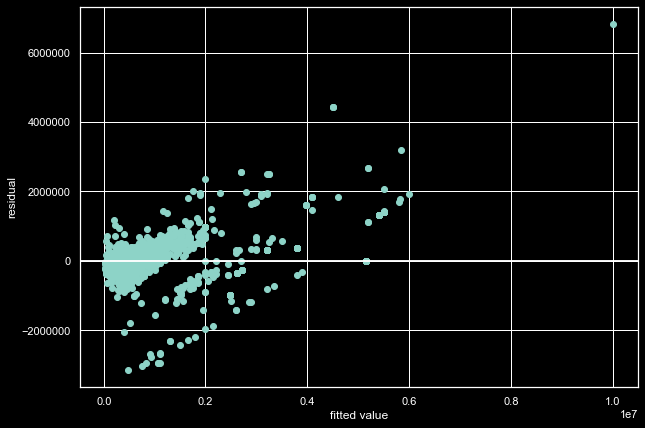

In [25]:
plt.figure(figsize = (10,7))
plt.scatter(y_train,model.resid.values)
plt.axhline(0.05)
plt.axhline(-0.05)
plt.xlabel('fitted value')
plt.ylabel('residual')
plt.show()

((array([-3.60407854, -3.366825  , -3.23596338, ...,  3.23596338,
          3.366825  ,  3.60407854]),
  array([-3141414.38608511, -3039496.0595369 , -2946339.32511931, ...,
          4421357.2132511 ,  4421357.2132511 ,  6819783.24535484])),
 (340894.6439549353, 7766.877261190855, 0.8345268440403996))

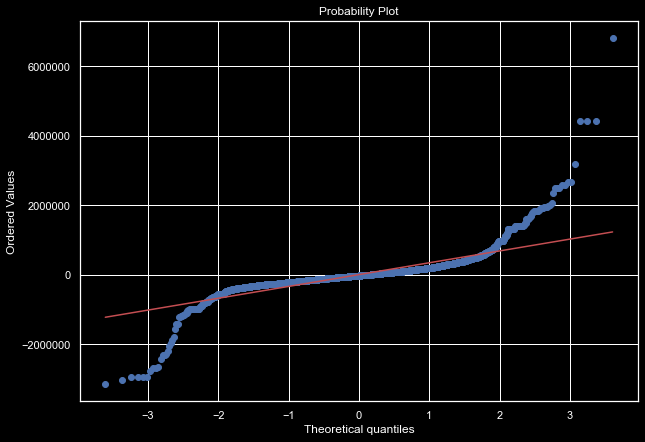

In [26]:
import scipy as sp
fig, ax = plt.subplots(figsize=(10,7))
sp.stats.probplot(model.resid.values, plot=ax, fit=True)

## Validação do Modelo

In [27]:
# Fazendo a predição
predictions = model.predict(X_test[selected_features_BE])
model.rsquared

0.8454080025394923

In [28]:
# Criando um DataFrame com o preço e suas prediçoes

df = pd.DataFrame({'selling_price':y_test, 'Resultado':predictions})

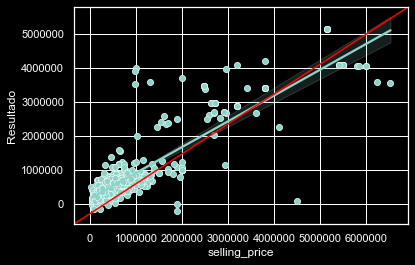

In [29]:
# Plotando o Grafico do preço em relaçao às prediçoes
import matplotlib.lines as mlines

fig, ax = plt.subplots()
sns.regplot(x="selling_price", y="Resultado", data=df);
sns.scatterplot(x='selling_price',y='Resultado', data=df)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

In [30]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df['selling_price'],predictions)
print ("r-squared:", r_value**2)

r-squared: 0.7722691779144422


---

# Criando o CSV para o Kaggle

In [31]:
predictions_test = model.predict(test_lr[selected_features_BE])
predictions_test

0       5.360755e+05
1       7.546453e+05
2       3.141170e+05
3       1.069943e+06
4       7.786283e+05
            ...     
2369    2.259946e+05
2370    5.953303e+05
2371    4.853078e+05
2372    3.538868e+05
2373    5.249687e+05
Length: 2374, dtype: float64

In [32]:
df_test = predictions_test.to_frame(name='selling_price')
df_test = df_test.rename_axis('id').reset_index()
df_test

,id,selling_price
0,0,5.360755e+05
1,1,7.546453e+05
2,2,3.141170e+05
3,3,1.069943e+06
4,4,7.786283e+05
...,...,...
2369,2369,2.259946e+05
2370,2370,5.953303e+05
2371,2371,4.853078e+05
2372,2372,3.538868e+05


In [33]:
'''
Terceiro deploy = 20h00 do dia 04/06/2021
'''
df_test.to_csv('Teste_3-Hugo_Azevedo.csv', index=False)